# Introduction to Improved Wasserstein Generative Adversarial Network

## Prerequisites

### Knowledge
- https://arxiv.org/pdf/1704.00028.pdf
### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

### Data

In [2]:
batch_size = 100

# Load the dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1. # [0, 2] - 1 => [-1, 1]
X_train = np.expand_dims(X_train, axis=3)

# Labels for real and fake examples
real = -np.ones((batch_size, 1))
fake = np.ones((batch_size, 1))

print(X_train.shape, np.min(X_train), np.max(X_train), X_train.dtype)

(60000, 28, 28, 1) -1.0 1.0 float64


## WGAN-GP for MNIST 

### Generator

In [3]:
def generator(): 
    model = tf.keras.Sequential([# Reshape input into 7x7x128 tensor via a fully connected layer
                                 tf.keras.layers.Dense(256 * 7 * 7, activation='relu'),
                                 tf.keras.layers.Reshape((7, 7,256)),
                                 # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
                                 tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0),
                                 # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
                                 tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0),
                                 # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
                                 tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.Activation('tanh')])
    return model

generator = generator()

### Critic

In [4]:
def critic():
    model = tf.keras.Sequential([# Convolutional layer, from 28x28x1 into 14x14x32 tensor
                                 tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Convolutional layer, from 14x14x32 into 7x7x64 tensor
                                 tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
                                 tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Flatten the tensor and apply sigmoid activation function
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(1)])
    return model

critic = critic()

### Wasserstein loss

In [5]:
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

### Training

In [6]:
generator_opt = tf.keras.optimizers.RMSprop(lr=0.00005)
critic_opt = tf.keras.optimizers.RMSprop(lr=0.00005)

In [7]:
@tf.function
def calculate_gradient_penalty(real_images, fake_images):
    with tf.GradientTape(persistent=True) as tape:
        # construct weighted average between real nd fake images and determite validity of it
        alpha = tf.random.uniform(shape=(real_images.shape[0], 1, 1, 1), dtype=tf.float64)
        interpolated_img = (alpha * real_images) + ((1 - alpha) * fake_images)
        validity_interpolated = critic(interpolated_img)
        
        #computes gradient penalty based on prediction and weighted real/fake samples
        gradient = tape.gradient(validity_interpolated, critic.trainable_variables)
        penalty = []
        for g in gradient:
            g_square = tf.math.square(g)
            g_square_sum = tf.reduce_sum(g_square, axis=np.arange(1, len(g.shape)))
            g_l2_norm = tf.math.sqrt(g_square_sum)
            g_penalty = tf.square(1 - g_l2_norm)
            penalty.append(g_penalty)
        penalty = tf.reduce_mean(penalty)
        
        # update gradient with penalty
        gradient = tape.gradient(penalty, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradient, critic.trainable_variables))
    return penalty

In [8]:
@tf.function
def train_critic(X_real, y_real, X_fake, y_fake):
    with tf.GradientTape(persistent=True) as tape:
        # Discriminator loss and train discriminator on fake and real images
        d_loss_real, d_accuracy_real = calculate_critic_loss(X_real, y_real)
        d_loss_fake, d_accuracy_fake = calculate_critic_loss(X_fake, y_fake)
        d_loss = 0.5 * tf.math.add(d_loss_real, d_loss_fake)
        d_accuracy = 0.5 * tf.math.add(d_accuracy_real, d_accuracy_fake)
        
        # construct weighted average between real nd fake images and determite validity of it
        alpha = tf.random.uniform(shape=(X_real.shape[0], 1, 1, 1), dtype=tf.float64)
        interpolated_img = (alpha * X_real) + ((1 - alpha) * X_fake)
        validity_interpolated = critic(interpolated_img)
        
        # calculate l2 loss for gradient penalty
        gradient = tape.gradient(validity_interpolated, critic.trainable_variables)
        penalty = []
        for g in gradient:
            g_square = tf.math.square(g)
            g_square_sum = tf.reduce_sum(g_square)
            g_l2_norm = tf.math.sqrt(g_square_sum)
            g_penalty = tf.square(1 - g_l2_norm)
            penalty.append(g_penalty)
        penalty = tf.reduce_mean(penalty)
        
        critic_loss = d_loss + penalty
        # update gradient with penalty
        gradient = tape.gradient(critic_loss, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradient, critic.trainable_variables))
    return critic_loss, d_accuracy, penalty

In [9]:
@tf.function
def calculate_critic_loss(image, label):
    # calculate loss
    prediction = critic(image)
    loss = wasserstein_loss(y_true=label, y_pred=prediction)
    accuracy = tf.reduce_mean(tf.keras.metrics.binary_accuracy(y_true=label, y_pred=prediction))
    return loss, accuracy

In [10]:
@tf.function
def train_generator(z_sample, label):
    with tf.GradientTape() as tape:
        image = generator(z_sample)
        prediction = critic(image)
        loss = wasserstein_loss(y_true=label, y_pred=prediction)
        # gradient descent and only update generator
        gradients = tape.gradient(loss, generator.trainable_variables)
        generator_opt.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

    0/10000 [..............................] - ETA: 0sIteration 0 d_loss 3076.4444917589794 g_loss -0.0013048137675363174 accuracy 0.0 penalty 3076.4331131804283


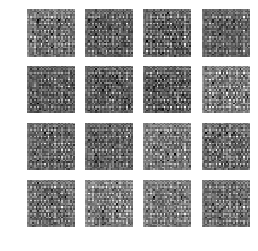

 2000/10000 [=====>........................] - ETA: 1:53:14Iteration 2000 d_loss 817.2809909093819 g_loss -0.00022066630194860496 accuracy 0.0 penalty 817.2814744206354


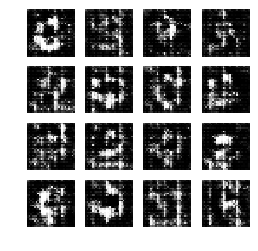

 4000/10000 [===========>..................] - ETA: 1:24:46Iteration 4000 d_loss 816.7745703996954 g_loss 0.0017704685515857338 accuracy 0.0 penalty 816.7748027994958


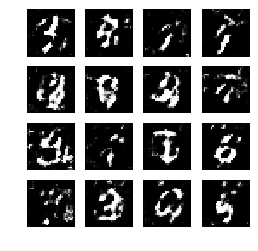

 6000/10000 [=================>............] - ETA: 56:28Iteration 6000 d_loss 816.7569559909942 g_loss 0.0010709333172309154 accuracy 0.0 penalty 816.7572654902218


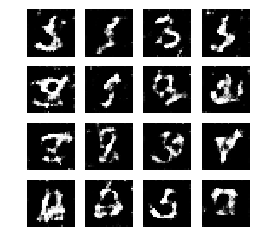

 8000/10000 [=======================>......] - ETA: 28:13Iteration 8000 d_loss 816.7528538952798 g_loss 0.000778183331110276 accuracy 0.0 penalty 816.7531690514298


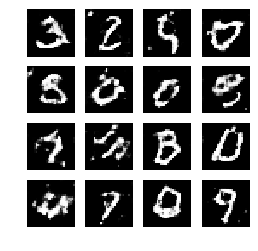

 9999/10000 [============================>.] - ETA: 0s

In [11]:
# init lists for losses and accuracies
d_losses, d_accuracies, g_losses, penalties = [], [], [], []

# defining the z dimension
z_dim = 100

# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01

ITERATIONS = 10000
prog = tf.keras.utils.Progbar(ITERATIONS)
for i in range(ITERATIONS):
    
    for _ in range(n_critic):
        # pick a random sample from the datas
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        image = X_train[idx]

        # Generate a batch of fake images
        z_sample = np.random.normal(0, 1, (batch_size, z_dim))
        gen_image = generator(z_sample)

        # Discriminator loss and train discriminator on fake and real images
        d_loss, d_accuracy, penalty = train_critic(image, real, gen_image, fake)
        
    # Generator loss
    g_loss = train_generator(z_sample, real)
    prog.update(i)
    
    # visualization
    if i % 2000 == 0:
        d_loss = d_loss.numpy()
        g_loss = g_loss.numpy()
        d_accuracy = d_accuracy.numpy()
        penalty = penalty.numpy()
        print("Iteration", i, "d_loss", d_loss, "g_loss", g_loss, "accuracy", d_accuracy, "penalty", penalty)
        image_grid_rows=4
        image_grid_columns=4

        # Sample random noise
        z_sample = np.random.normal(0, 1, 
                  (image_grid_rows * image_grid_columns, z_dim))

        # Generate images from random noise 
        gen_imgs = generator(z_sample)
        # Rescale images to 0-1
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Set image grid
        fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                        figsize=(image_grid_rows,image_grid_columns), sharey=True, sharex=True)
        cnt = 0
        for m in range(image_grid_rows):
            for n in range(image_grid_columns):
                # Output image grid
                axs[m,n].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[m,n].axis('off')
                cnt += 1
        plt.show()
        
        d_losses.append(d_loss)
        d_accuracies.append(d_accuracy)
        g_losses.append(g_loss)
        penalties.append(penalty)

### Visualization

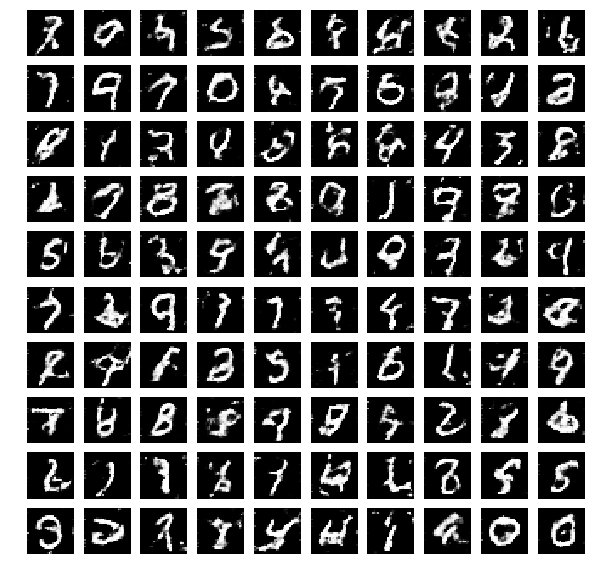

In [12]:
image_grid_rows=10
image_grid_columns=10

# Sample random noise
z_sample = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

# Generate images from random noise 
gen_imgs = generator(z_sample)
# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10,10), sharey=True, sharex=True)
cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

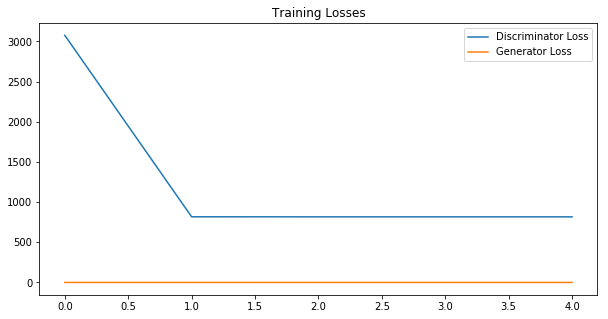

In [13]:
# Plot training losses for Discriminator and Generator
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Training Losses")
plt.legend()

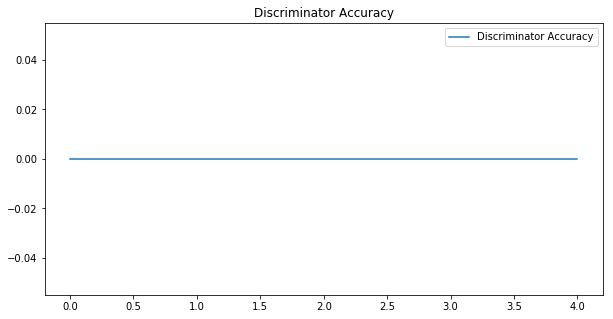

In [14]:
accuracies = np.array(d_accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()